## Step 1: Prepare Your Synthetic Dataset

To train the LSTM model, we need a time-series dataset simulating ballot drop events. Since actual voting data might not be available, we'll create a **synthetic dataset** with the following columns:
- **`timestamp`**: Time intervals (e.g., every minute)
- **`ballots_dropped`**: Number of ballots dropped at each timestamp (mostly normal values, with occasional large spikes to simulate anomalies)

In [22]:
import pandas as pd
import numpy as np

# Generate synthetic timestamps (1-minute intervals)
timestamps = pd.date_range('2025-07-01 07:00:00', periods=500, freq='5T')

# Simulate ballot drops (normal 1 drop per 5-minute interval)
np.random.seed(42)
ballots_dropped = np.ones(500, dtype=int)

# Inject anomalies: 2 to 4 drops in a 5-minute interval (suspicious)
anomaly_indices = np.random.choice(500, 15, replace=False)
ballots_dropped[anomaly_indices] = np.random.randint(2, 5, size=15)

# Create dataframe
df = pd.DataFrame({
    'timestamp': timestamps,
    'ballot_box_id': 'Box_1',
    'ballots_dropped': ballots_dropped
})

# Save as CSV
df.to_csv('synthetic_ballot_drops_per_box.csv', index=False)


/tmp/ipython-input-22-1935307459.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timestamps = pd.date_range('2025-07-01 07:00:00', periods=500, freq='5T')


## Step 2: Load and Inspect the Dataset

In this step, we load the synthetic dataset of ballot drop sessions and inspect the data before preparing it for modeling.

The dataset simulates ballot drops at a **single ballot box**, with:
- **5-minute intervals** as the timestamp.
- **1 expected drop** per interval under normal operation.
- Occasional **anomalous spikes** representing multiple ballot drops within a 5-minute period.


In [23]:
# Load the CSV file (specific to one ballot box)
df = pd.read_csv('synthetic_ballot_drops_per_box.csv')

# Inspect the first few rows
df.head()



,timestamp,ballot_box_id,ballots_dropped
0,2025-07-01 07:00:00,Box_1,1
1,2025-07-01 07:05:00,Box_1,1
2,2025-07-01 07:10:00,Box_1,1
3,2025-07-01 07:15:00,Box_1,1
4,2025-07-01 07:20:00,Box_1,1


## Step 3: Preprocess Data for LSTM

To train the LSTM model effectively, we need to:
- **Normalize** the `ballots_dropped` values using Min-Max scaling.
- **Transform the time-series data into sequences**, where:
  - Each sequence covers **10 consecutive 5-minute intervals** (representing 50 minutes).
  - The model will learn to predict the **next interval's ballot drop count** based on the previous 10.

This step prepares the data in the correct shape for LSTM training, which expects input in the form:
- `(samples, time_steps, features)`

In [24]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Scale the ballots_dropped
scaler = MinMaxScaler()
df['scaled_ballots_dropped'] = scaler.fit_transform(df[['ballots_dropped']])

# Create sequences (window size = 10)
window_size = 10
X = []
y = []

data = df['scaled_ballots_dropped'].values

for i in range(len(data) - window_size):
    X.append(data[i:i+window_size])
    y.append(data[i+window_size])  # Predict the next point

X = np.array(X)
y = np.array(y)

# Reshape X for LSTM (samples, time_steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))


## Step 4: Build and Train the LSTM Model

In this step, we build a **Long Short-Term Memory (LSTM)** model using TensorFlow/Keras to learn the time-series pattern of ballot drop events.

### Model Overview:
- **LSTM Layer**: Captures temporal dependencies in the sequence data (past ballot drop patterns).
- **Dense Layer**: Outputs a single predicted ballot drop count for the next interval.
- **Loss Function**: Mean Squared Error (`mse`), suitable for regression tasks.
- **Optimizer**: Adam, for efficient gradient descent optimization.

The model is trained to predict the **next ballot drop count** based on the previous **10 intervals** (50 minutes).


In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential([
    LSTM(50, input_shape=(window_size, 1)),
    Dense(1)  # Predict the next ballot drop count
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X, y, epochs=20, batch_size=32)



Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0150
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0108
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0090
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0114
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0087
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0122
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0153
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0123
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0149
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0137
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0112
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0130
Epoch 13/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0120
Epoch 14/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0113
Epoch 15/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0099
Epoch 16/20
16/16 ━━━

## Step 5: Detect Voting Anomalies

After training the LSTM model, we can detect **anomalous ballot drop patterns** by comparing the model’s predictions to the actual ballot drop counts.

### Approach:
- Generate predictions using the trained LSTM model.
- Calculate the **absolute error** between predicted and actual ballot drop counts.
- Define an **anomaly threshold** as:
  - Mean prediction error + 2 × Standard Deviation of the errors.
- Any time step with an error exceeding this threshold is flagged as an **anomaly**.

This approach helps identify unusually large deviations from normal voting behavior, signaling potential suspicious activity (e.g., multiple ballot drops in a short period).


In [26]:
predictions = model.predict(X)

# Calculate absolute errors
errors = np.abs(predictions.flatten() - y)

# Define anomaly threshold: mean error + 2 * standard deviation
threshold = errors.mean() + 2 * errors.std()

# Identify anomalies (True if error exceeds threshold)
anomalies = errors > threshold

# Mark anomalies in the original dataframe
df['anomaly'] = False
df.loc[window_size:, 'anomaly'] = anomalies  # Start marking after initial window



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


##  Step 6: Visualize Detected Anomalies

To easily interpret the results, we plot:
- The **actual ballot drop counts** over time.
- **Anomalies** highlighted in red, indicating intervals where the ballot drop pattern deviated significantly from what the LSTM model expected.

This visualization helps to quickly identify periods of suspicious voting activity.


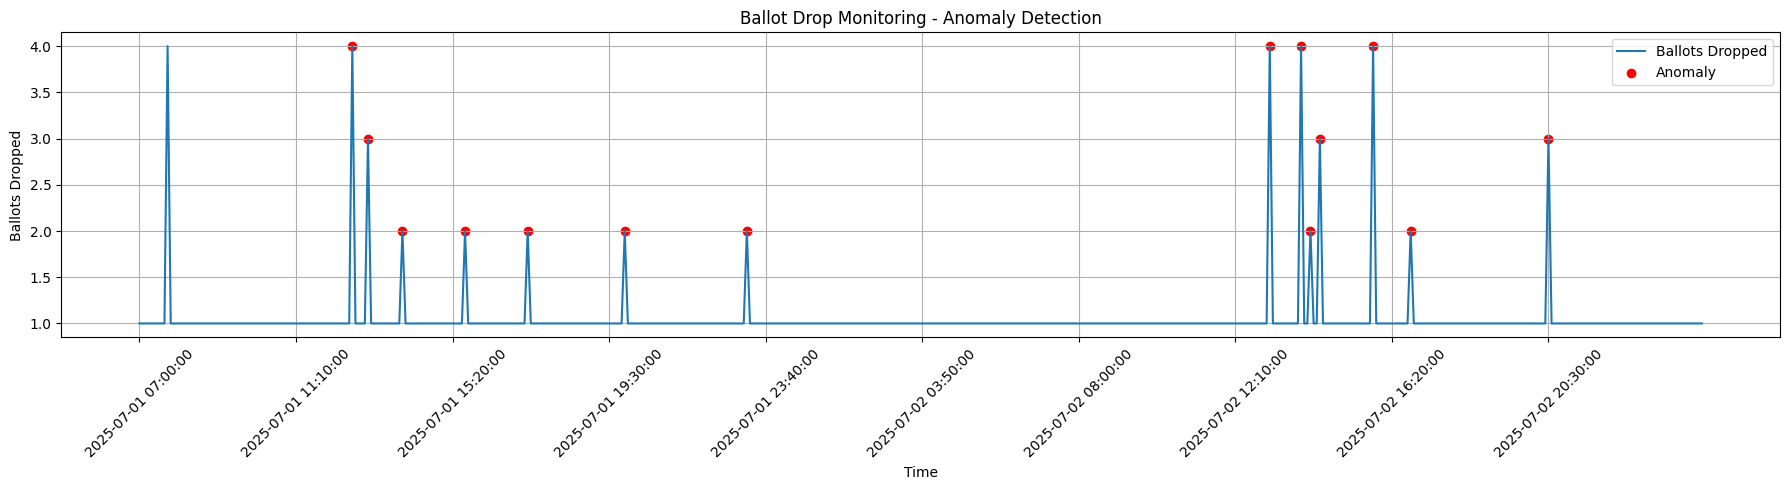

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,5))

# Plot ballot drops
plt.plot(df['timestamp'], df['ballots_dropped'], label='Ballots Dropped')

# Plot anomalies
plt.scatter(
    df.loc[df['anomaly'], 'timestamp'],
    df.loc[df['anomaly'], 'ballots_dropped'],
    color='red',
    label='Anomaly'
)

# Customize plot
plt.xlabel('Time')
plt.ylabel('Ballots Dropped')
plt.title('Ballot Drop Monitoring - Anomaly Detection')
plt.legend()
plt.grid(True)

plt.xticks(ticks=range(0, len(df), 50), rotation=45)  # Show every 50th timestamp

plt.tight_layout()
plt.show()



In [30]:
model.save('voting_anomaly_detector.keras')

In [32]:
from fastapi import FastAPI
from pydantic import BaseModel
import tensorflow as tf
import numpy as np

# Load trained model (saved as .keras)
model = tf.keras.models.load_model('voting_anomaly_detector.keras', compile=False)

# Define input format
class InputData(BaseModel):
    ballot_sequence: list  # 10 previous ballot drops

# Initialize FastAPI app
app = FastAPI()

# Define prediction endpoint
@app.post("/predict")
def detect_anomaly(data: InputData):
    sequence = np.array(data.ballot_sequence).reshape((1, 10, 1))
    prediction = model.predict(sequence)
    return {"predicted_next_drop": float(prediction[0][0])}


In [33]:
from fastapi import FastAPI
from pydantic import BaseModel
import tensorflow as tf
import numpy as np

# Load the trained model (ready for predictions)
model = tf.keras.models.load_model('voting_anomaly_detector.keras', compile=False)

# Define FastAPI app
app = FastAPI()

# Define input format using Pydantic
class InputData(BaseModel):
    ballot_sequence: list  # List of last 10 ballot drop counts

# Define endpoint
@app.post("/predict")
def predict_next_ballot_drop(data: InputData):
    sequence = np.array(data.ballot_sequence).reshape((1, 10, 1))  # Format for LSTM
    prediction = model.predict(sequence)
    predicted_value = float(prediction[0][0])  # Convert to Python float for JSON

    return {
        "predicted_next_ballot_drop": predicted_value
    }



In [34]:
from google.colab import files
files.download('voting_anomaly_detector.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>